In [1]:
# 1. Load the pre-trained model and processor
import random
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load the model and processor
processor = AutoImageProcessor.from_pretrained("gaborcselle/font-identifier")
model = AutoModelForImageClassification.from_pretrained(
    "gaborcselle/font-identifier",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Inspect how the original classifier is built
print(model.classifier)

# Replace the final linear layer or insert dropout layers so that
# the overall structure is still recognized
in_features = model.classifier[-1].in_features  # or whichever layer is the final linear
model.classifier[-1] = nn.Linear(in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at gaborcselle/font-identifier and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([49]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([49, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [2]:

# Section 2: Dataset Preparation with Correct Label Mapping
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Dataset path
# /data/comic and /data/not-comic
data_dir = "./data"

# Apply augmentations and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset WITHOUT label flipping
full_dataset = datasets.ImageFolder(
    data_dir,
    transform=transform
    # Removed the target_transform that was flipping labels
)

# Verify class-to-index mapping
print(f"Class-to-Index Mapping: {full_dataset.class_to_idx}")

# Train/Validation Split
train_size = int(0.8 * len(full_dataset))  # 80% train, 20% validation
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Class-to-Index Mapping: {'comic': 0, 'not-comic': 1}
Total dataset size: 170
Training set size: 136
Validation set size: 34


In [3]:

# 3. Fine-Tuning: Optimizer with weight decay and learning rate scheduler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler with increased patience
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [4]:

# 4. Training Loop with Scheduler and Regularization
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs).logits
            val_loss += criterion(logits, labels).item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    scheduler.step(val_loss / len(val_loader))  # Adjust learning rate

    print(f"Epoch {epoch+1}: Train Loss={total_loss/len(train_loader):.4f}, "
          f"Val Loss={val_loss/len(val_loader):.4f}, Accuracy={correct/total:.2%}")


Epoch 1: Train Loss=0.7219, Val Loss=0.9563, Accuracy=52.94%
Epoch 2: Train Loss=0.4066, Val Loss=0.4866, Accuracy=67.65%
Epoch 3: Train Loss=0.3505, Val Loss=0.4192, Accuracy=76.47%
Epoch 4: Train Loss=0.2566, Val Loss=0.4278, Accuracy=79.41%
Epoch 5: Train Loss=0.1519, Val Loss=0.4367, Accuracy=73.53%
Epoch 6: Train Loss=0.1517, Val Loss=0.4523, Accuracy=73.53%
Epoch 7: Train Loss=0.0696, Val Loss=0.4988, Accuracy=73.53%
Epoch 8: Train Loss=0.0664, Val Loss=0.4990, Accuracy=73.53%
Epoch 9: Train Loss=0.1102, Val Loss=0.3328, Accuracy=76.47%
Epoch 10: Train Loss=0.0584, Val Loss=0.4848, Accuracy=67.65%
Epoch 11: Train Loss=0.0558, Val Loss=0.5474, Accuracy=67.65%
Epoch 12: Train Loss=0.0312, Val Loss=0.5317, Accuracy=70.59%
Epoch 13: Train Loss=0.0304, Val Loss=0.4936, Accuracy=76.47%
Epoch 14: Train Loss=0.0235, Val Loss=0.5435, Accuracy=67.65%
Epoch 15: Train Loss=0.0426, Val Loss=0.4894, Accuracy=67.65%
Epoch 16: Train Loss=0.0316, Val Loss=0.6098, Accuracy=70.59%
Epoch 17: Train L

In [5]:
# 5. Save Fine-Tuned Model
# Update the model's complete config
model.config._name_or_path = "comic-sans-detector"  # Update the name
model.config.id2label = {0: "comic", 1: "not-comic"}
model.config.label2id = {"comic": 0, "not-comic": 1}
model.config.num_labels = 2
model.config.problem_type = "single_label_classification"

# Print config to verify
print("Model path:", model.config._name_or_path)
print("id2label:", model.config.id2label)
print("label2id:", model.config.label2id)
print("num_labels:", model.config.num_labels)
print("problem_type:", model.config.problem_type)

# Create output directory and save
import os
output_dir = "./comic-sans-detector"
os.makedirs(output_dir, exist_ok=True)

# Save both the model and its configuration
model.save_pretrained(output_dir)  # Removed deprecated save_config parameter
processor.save_pretrained(output_dir)

# After saving
print("\nVerifying saved and loaded models match:")
print("Original model classifier:")
print(model.classifier)

# Load and verify
loaded_model = AutoModelForImageClassification.from_pretrained(output_dir)
print("\nLoaded model classifier:")
print(loaded_model.classifier)

# Compare a few random weights to ensure they match
print("\nComparing weights:")
orig_weights = model.classifier[1].weight
loaded_weights = loaded_model.classifier[1].weight
print(f"Original first few weights: {orig_weights[0, :5]}")
print(f"Loaded first few weights: {loaded_weights[0, :5]}")
print(f"Weights match: {torch.allclose(orig_weights, loaded_weights)}")

Model path: comic-sans-detector
id2label: {0: 'comic', 1: 'not-comic'}
label2id: {'comic': 0, 'not-comic': 1}
num_labels: 2
problem_type: single_label_classification

Verifying saved and loaded models match:
Original model classifier:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=2, bias=True)
)

Loaded model classifier:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=2, bias=True)
)

Comparing weights:
Original first few weights: tensor([ 0.0101,  0.0112, -0.0308,  0.0408,  0.0240], grad_fn=<SliceBackward0>)
Loaded first few weights: tensor([ 0.0101,  0.0112, -0.0308,  0.0408,  0.0240], grad_fn=<SliceBackward0>)
Weights match: True


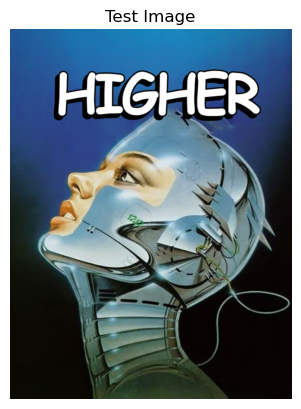

Results:
Comic Sans: 99.96%
Not Comic Sans: 0.04%


In [6]:

# 6. Test Using Model
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the image
image_path = "./data/comic/test_sample.png"
image = Image.open(image_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Preprocess and run inference
inputs = processor(images=image, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs).logits
    probs = torch.softmax(outputs, dim=-1)

    # Get probabilities for both classes
    comic_prob = probs[0][0].item()  # Index 0 for "comic"
    not_comic_prob = probs[0][1].item()  # Index 1 for "not-comic"

# Print results
print(f"Results:")
print(f"Comic Sans: {comic_prob:.2%}")
print(f"Not Comic Sans: {not_comic_prob:.2%}")

Model Configuration:
id2label: {0: 'comic', 1: 'not-comic'}
label2id: {'comic': 0, 'not-comic': 1}



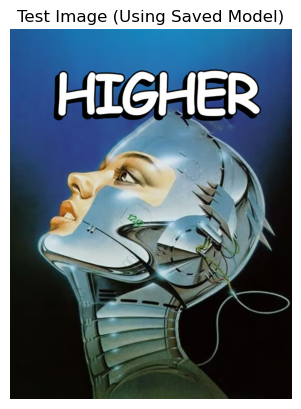

Results from saved model:
Comic Sans: 99.96%
Not Comic Sans: 0.04%
Saved model classifier structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


In [7]:
# 7. Test Using Saved Model Version
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model and processor
saved_model = AutoModelForImageClassification.from_pretrained("./comic-sans-detector")
saved_processor = AutoImageProcessor.from_pretrained("./comic-sans-detector")

# Print model configuration to verify labels
print("Model Configuration:")
print(f"id2label: {saved_model.config.id2label}")
print(f"label2id: {saved_model.config.label2id}\n")

# Move model to device
saved_model.to(device)

# Load and display the same test image
image_path = "./data/comic/test_sample.png"
image = Image.open(image_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title("Test Image (Using Saved Model)")
plt.show()

# Preprocess and run inference
inputs = saved_processor(images=image, return_tensors="pt").to(device)

saved_model.eval()
with torch.no_grad():
    outputs = saved_model(**inputs).logits
    probs = torch.softmax(outputs, dim=-1)

    # Get probabilities for both classes - matching the order from block 5
    comic_prob = probs[0][0].item()  # Index 0 for "comic"
    not_comic_prob = probs[0][1].item()  # Index 1 for "not-comic"

# Print results
print(f"Results from saved model:")
print(f"Comic Sans: {comic_prob:.2%}")
print(f"Not Comic Sans: {not_comic_prob:.2%}")

# After loading the saved model
print("Saved model classifier structure:")
print(saved_model.classifier)